In [3]:
# Data packages
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Math
import math
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# Import weights & Biases
import wandb


In [4]:
path = r'FLAC\FLAC2D\1D 1 Column\Results2'

In [5]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(750, 1000) (750,) (1000,)


In [6]:
print("Output shape: ", TTF_data.shape)
print("Input shape: ", Vs_data.shape)

Output shape:  (750, 1000)
Input shape:  (750,)


In [7]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [8]:
dataset = TTF_dataset(TTF_data, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  750
Data shapes for input and target:  torch.Size([30]) torch.Size([1000])
Train, validation and test sizes:  600 75 75
Number of batches:  12 2 2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FNO1d(nn.Module):
    def __init__(self, modes, width, output_in_fourier=False):

        super(FNO1d, self).__init__()

        """
        Args:
            modes (int): Number of Fourier modes to keep (positive frequencies).
            width (int): Number of channels (features) in the input and output.
        """
        self.modes = modes
        self.width = width

        self.scale = (1 / (width ** 0.5))
        self.weights = nn.Parameter(self.scale * torch.randn(modes, width, width, 2, dtype=torch.float))
        self.output_in_fourier = output_in_fourier

    def forward(self, x):
        batchsize = x.shape[0]
        length = x.shape[1]
        width = x.shape[2]

        # Compute Fourier transform
        x_ft = torch.fft.rfft(x, dim=1, norm='ortho')

        # Allocate output in frequency domain
        out_ft = torch.zeros(batchsize, length // 2 + 1, width, dtype=torch.cfloat, device=x.device)

        # Keep only the lower modes
        modes = min(self.modes, length // 2)

        # Get the indices of the modes to keep
        indices = torch.arange(0, modes, device=x.device)

        # Complex multiplication of the low frequency modes
        weights = torch.view_as_complex(self.weights)
        out_ft[:, indices, :] = self.compl_mul1d(x_ft[:, indices, :], weights)

        if self.output_in_fourier:
            return out_ft
        else:
            # Return to physical space
            x = torch.fft.irfft(out_ft, n=length, dim=1, norm='ortho')
            return x

    def compl_mul1d(self, input, weights):
        # (batch, mode, width), (mode, width_in, width_out) -> (batch, mode, width_out)
        return torch.einsum("bmw,mwo->bmo", input, weights)

class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding='same') # Kernel size adjusted
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2) # Output size: 15
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding='same') # Output size: 15
        self.maxpool2 = nn.MaxPool1d(kernel_size=2) # Output size: 7
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding='same') # Output size: 7
        self.maxpool3 = nn.MaxPool1d(kernel_size=2) # Output size: 3
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding='same') # Output size: 3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 256, latent_dim) # Adjusted flattened size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class OperatorDecoder(nn.Module):
    def __init__(self, latent_dim, output_size, fno_modes, fno_width, fno_channels):
        super(OperatorDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, fno_width * output_size)
        self.relu = nn.ReLU()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(fno_width, output_size))
        self.fno1 = FNO1d(modes=fno_modes, width=fno_width)
        self.fno2 = FNO1d(modes=fno_modes, width=fno_width, output_in_fourier=False)
        self.fc2 = nn.Linear(fno_width, 1)

    def forward(self, z):
        x = self.fc1(z)
        #x = self.relu(x)
        x = self.unflatten(x).permute(0, 2, 1) # Shape: (batch_size, output_size, fno_width)
        x = self.fno1(x)
        #print("Shape after FNO1: ", x.shape)
        # Back to FFT space
        x = self.fno2(x)
        #print("Shape after FNO2: ", x.shape)
        x = self.fc2(x).squeeze(-1) # Shape: (batch_size, output_size)
        return x

class EncoderOperatorModel(nn.Module):
    def __init__(self, input_size, latent_dim, output_size, fno_modes=16, fno_width=64, fno_channels=1):
        super(EncoderOperatorModel, self).__init__()
        self.encoder = Encoder(input_size, latent_dim)
        self.operator_decoder = OperatorDecoder(latent_dim, output_size, fno_modes, fno_width, fno_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.operator_decoder(encoded)
        return decoded

# Define the input and output sizes
input_size = 30
output_size = 1000
latent_dim = 64 # Adjust latent dimension as needed

# FNO parameters
fno_modes = 50
fno_width = 64
fno_channels = 1

# Create an instance of the model with the operator decoder
model = EncoderOperatorModel(input_size, latent_dim, output_size, fno_modes, fno_width, fno_channels)

# Example of how to use it with dummy data
batch_size = 50
dummy_input = torch.randn(batch_size, input_size)
output = model(dummy_input)
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([50, 30])
Output shape: torch.Size([50, 1000])


In [10]:
from matplotlib.animation import FuncAnimation

def visualize_validation(model, val_loader, freq_data, example_idx=0, epoch=0):
    """
    Visualizes the model's prediction on a specific example from the validation set.

    Args:
        model: The PyTorch model being trained.
        val_loader: DataLoader for the validation dataset.
        freq_data: Frequency data for plotting the transfer function.
        example_idx: Index of the example to visualize from the validation dataset.
        epoch: Current epoch number (for display purposes).
    """
    # Get the specific example from the validation dataset
    inputs, targets = next(iter(val_loader))
    inputs, targets = inputs[example_idx], targets[example_idx]
    inputs, targets = inputs.unsqueeze(0), targets.unsqueeze(0)  # Add batch dimension

    # Move data to the same device as the model
    device = next(model.parameters()).device
    inputs, targets = inputs.to(device), targets.to(device)

    # Perform a forward pass
    model.eval()
    with torch.no_grad():
        predictions = model(inputs).cpu().numpy().flatten()

    # Plot the ground truth and predictions
    plt.figure(figsize=(8, 6))
    plt.plot(freq_data, targets.cpu().numpy().flatten(), label="Ground Truth", color="blue", alpha=0.7)
    plt.plot(freq_data, predictions, label="Prediction", color="red", alpha=0.7)
    plt.title(f"Validation Example (Epoch {epoch + 1})", fontsize=16)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Transfer Function", fontsize=12)
    plt.xscale("log")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.savefig(f"./Animation/validation_example_epoch_{epoch + 1}.png", dpi=300)
    plt.close()

Using device: cuda


c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kurtwal98 (kurtwal98-university-of-california-berkeley). Use `wandb login --relogin` to force relogin


Epoch 1/20000, Train Loss: 26.400010, Val Loss: 23.777509
Model saved with validation loss: 23.777509
Epoch 2/20000, Train Loss: 23.990251, Val Loss: 23.544720
Model saved with validation loss: 23.544720
Epoch 3/20000, Train Loss: 23.740803, Val Loss: 23.599819
Epoch 4/20000, Train Loss: 23.641360, Val Loss: 23.314575
Model saved with validation loss: 23.314575
Epoch 5/20000, Train Loss: 23.612920, Val Loss: 23.304575
Model saved with validation loss: 23.304575
Epoch 6/20000, Train Loss: 23.536392, Val Loss: 23.332825
Epoch 7/20000, Train Loss: 23.478348, Val Loss: 23.190816
Model saved with validation loss: 23.190816
Epoch 8/20000, Train Loss: 23.360786, Val Loss: 23.171495
Model saved with validation loss: 23.171495
Epoch 9/20000, Train Loss: 23.298718, Val Loss: 23.026520
Model saved with validation loss: 23.026520
Epoch 10/20000, Train Loss: 23.188846, Val Loss: 22.943014
Model saved with validation loss: 22.943014
Epoch 11/20000, Train Loss: 23.119648, Val Loss: 22.826010
Model sa

epoch,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇███
learning_rate,█████▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,895
learning_rate,0.0
train_loss,0.71104
val_loss,0.76686


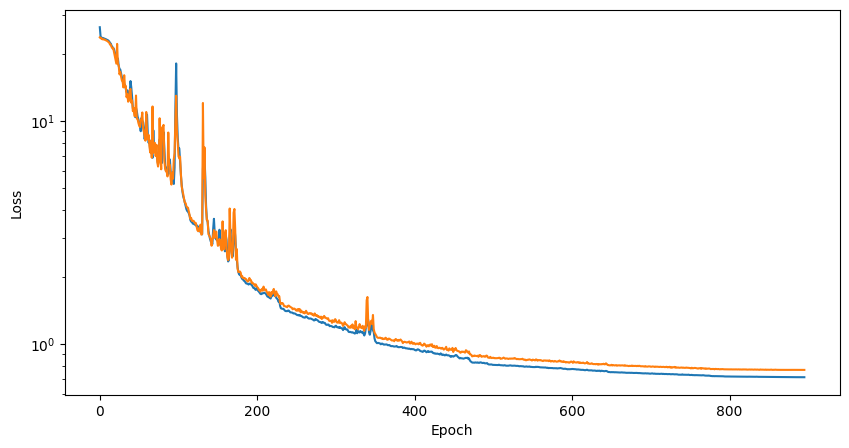

In [11]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
lr_set = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr_set, weight_decay=1e-5)
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

# Training parameters
num_epochs = 20000
best_val_loss = float('inf')
early_stop_patience = 15
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': []}

# Initialize wandb for experiment tracking
wandb.init(project="ttf-prediction", name="encoder-operator-model")
wandb.config.update({
    "epochs": num_epochs,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "learning_rate": lr_set,
    "latent_dim": latent_dim,
    "input_size": input_size,
    "output_size": output_size
})

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Log metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'learning_rate': optimizer.param_groups[0]['lr']
    })
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_ttf_model.pt')
        early_stop_counter = 0
        print(f'Model saved with validation loss: {val_loss:.6f}')
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= early_stop_patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

    # Visualize validation example every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_validation(model, val_loader, freq_data, example_idx=0, epoch=epoch)

wandb.finish()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

In [12]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_ttf_model.pt', weights_only=True))
model.eval()

# Compute predictions on the test set
test_predictions = []
test_targets = []
test_inputs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Store the predictions, targets, and inputs
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())
        test_inputs.append(inputs.cpu().numpy())

# Concatenate the batches
test_predictions = np.vstack(test_predictions)
test_targets = np.vstack(test_targets)
test_inputs = np.vstack(test_inputs)

# Calculate test loss
test_loss = np.mean((test_predictions - test_targets)**2)
test_L1_loss = np.mean(np.abs(test_predictions - test_targets))
print(f'Test L1 Loss: {test_L1_loss:.6f}')
print(f'Test MSE Loss: {test_loss:.6f}')


Test L1 Loss: 0.309534
Test MSE Loss: 0.751425


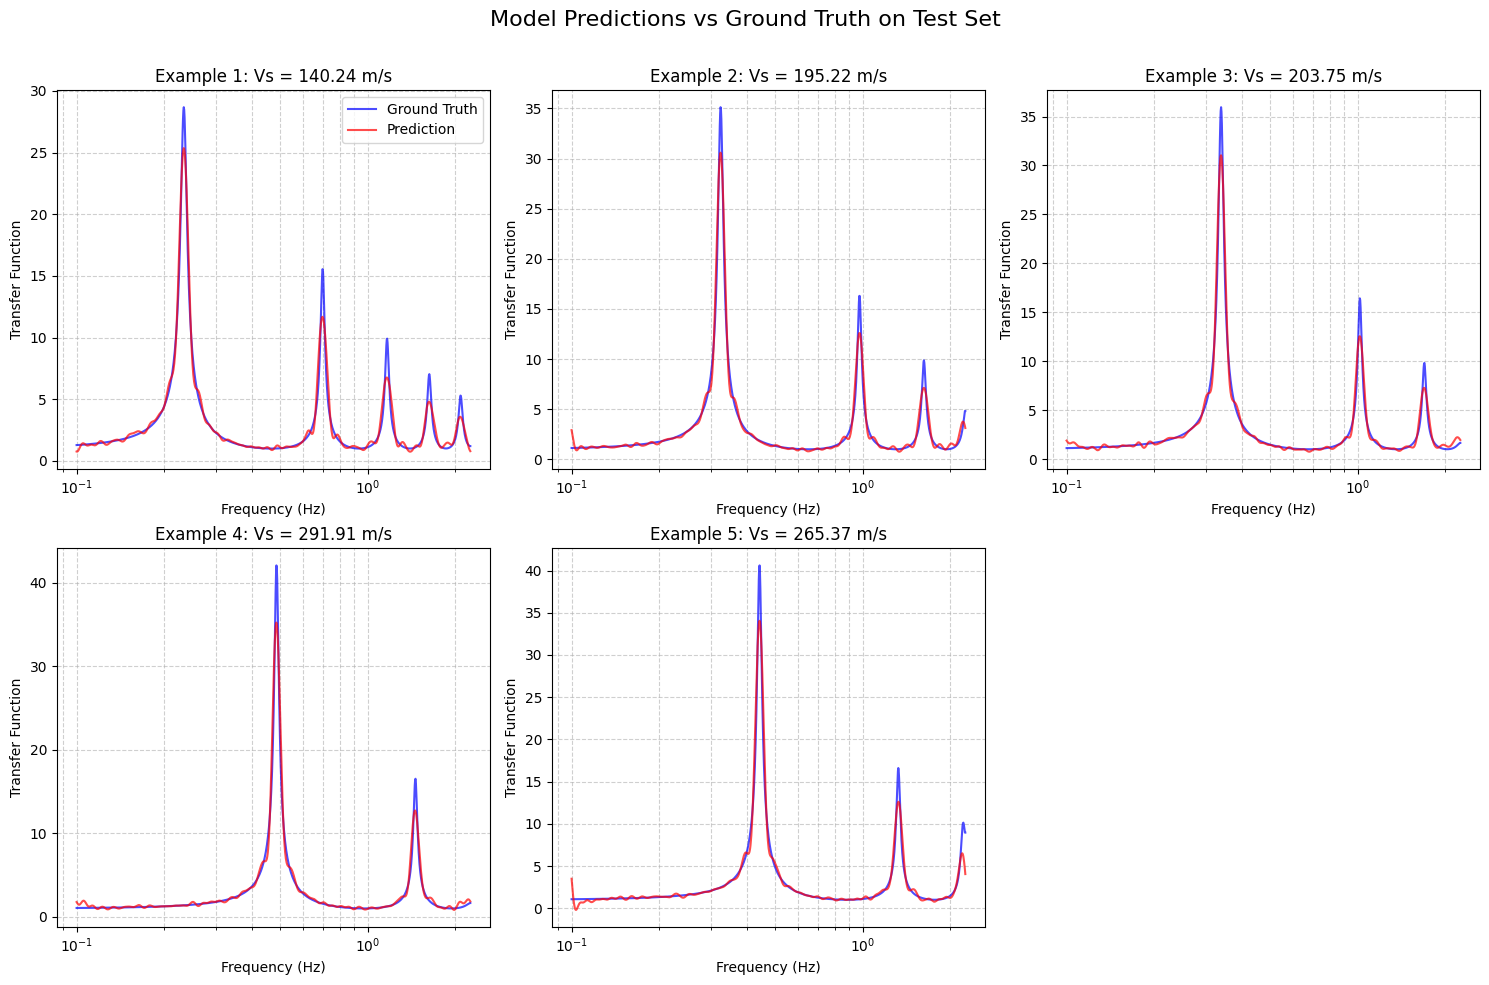

In [13]:
# Select 5 random indices from the test set
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(test_predictions), 5, replace=False)

# Create a figure to plot the 5 random examples
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    
    # Plot the target (ground truth)
    plt.plot(freq_data, test_targets[idx], 'b-', label='Ground Truth', alpha=0.7)
    
    # Plot the prediction
    plt.plot(freq_data, test_predictions[idx], 'r-', label='Prediction', alpha=0.7)
    
    # Show input Vs value
    vs_value = test_inputs[idx][0]  # Get the Vs value (same across the input array)
    plt.title(f'Example {i+1}: Vs = {vs_value:.2f} m/s')
    
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    
    # Only add legend to the first subplot
    if i == 0:
        plt.legend()
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Transfer Function')

plt.tight_layout()
plt.suptitle('Model Predictions vs Ground Truth on Test Set', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.savefig('test_predictions.png', dpi=300)
plt.show()

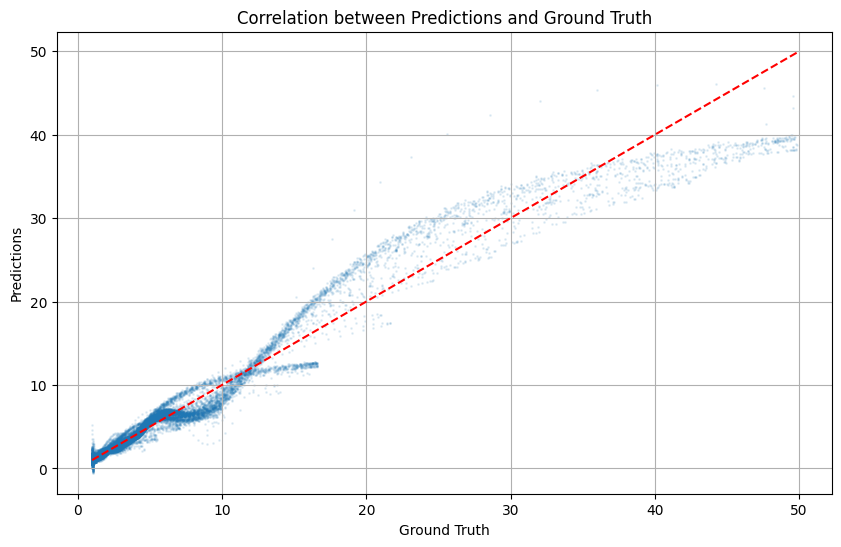

In [14]:
# Also plot the correlation between predictions and ground truth for all test samples
plt.figure(figsize=(10, 6))
plt.scatter(test_targets.flatten(), test_predictions.flatten(), alpha=0.1, s=1)
plt.plot([np.min(test_targets), np.max(test_targets)], 
         [np.min(test_targets), np.max(test_targets)], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Correlation between Predictions and Ground Truth')
plt.grid(True)
plt.savefig('prediction_correlation.png', dpi=300)
plt.show()

Text(0.5, 1.0, 'Histogram of Pearson Correlation Coefficients')

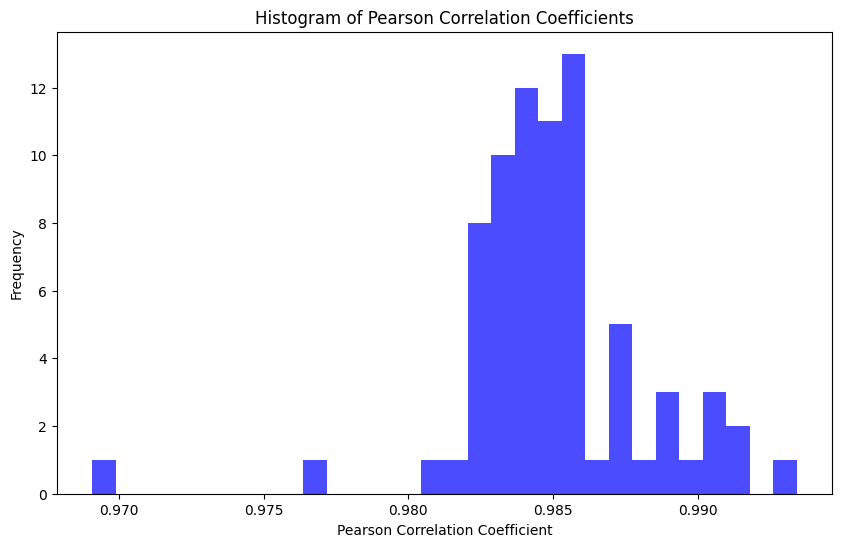

In [15]:
# Compute the pearson correlation coefficient
from scipy.stats import pearsonr

corr_coefficients = []
for i in range(len(test_predictions)):
    corr, _ = pearsonr(test_targets[i], test_predictions[i])
    corr_coefficients.append(corr)

# Plot the histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, alpha=0.7, color='blue')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Pearson Correlation Coefficients')

In [19]:
import imageio
import os
import re

def create_gif_from_validation_images(image_folder, output_gif_path, duration=0.5):
    """
    Creates a GIF animation from saved validation example images.

    Args:
        image_folder (str): Path to the folder containing the saved validation images.
        output_gif_path (str): Path to save the output GIF file.
        duration (float): Duration of each frame in the GIF (in seconds).
    """
    # Get all image file paths in the folder
    image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png")]

    # Extract epoch numbers using regex and sort the files
    image_files = sorted(image_files, key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))

    # Read images and create the GIF
    with imageio.get_writer(output_gif_path, mode="I", duration=duration) as writer:
        for image_file in image_files:
            image = imageio.imread(image_file)
            writer.append_data(image)

    print(f"GIF saved at {output_gif_path}")


# Example usage
# Assuming validation images are saved in "./Animation" folder
create_gif_from_validation_images(image_folder="./Animation", output_gif_path="validation_animation.gif", duration=0.5)

C:\Users\kurt-\AppData\Local\Temp\ipykernel_23256\3815595446.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)


GIF saved at validation_animation.gif
